# %% [markdown]

  # Transmission Chain Simulation: AST, Fragments, and Information Bottleneck

 cultural evolution of block-building programs through transmission chains.

 models:

  1. **Baseline (Noise-only)**: Random mutations without selection
  2. **Selection-based**: Token-level selection with compression-accuracy trade-off
  3. **AST-based IB**: Structured programs with fragment learning and explicit Information Bottleneck objective

 concepts:
  - **AST (Abstract Syntax Tree)**: Structured representation enabling compositionality
  - **Fragment Discovery**: Automatic learning of reusable program patterns
  - **Information Bottleneck (IB)**: Trade-off between compression (complexity) and fidelity (accuracy)

# %% [markdown]

  ## Setup and Imports

In [462]:
# %%

import os
import sys
import random
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make project root importable
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

from model.transmission.transmission_chain import (
    MANUAL_TOWER_PROGRAMS,
    TransmissionChain,
    DEFAULT_DSL,
    expanded_length,
    sequence_accuracy,
    expand_program,
    visual_overlap_score,
    run_chain_with_selection,
    run_chain_ib,
)

from model.dsl import tokens_to_ast, ast_to_tokens, set_library
from model.program_induction import fragment_usage, discover_fragments, apply_fragments
from model.eval import ib_complexity, ib_accuracy, ib_loss, tree_edit_distance

# Import block renderer for visual comparison
BLOCK_UTILS_DIR = os.path.join(ROOT_DIR, "model", "block_utils")
if BLOCK_UTILS_DIR not in sys.path:
    sys.path.append(BLOCK_UTILS_DIR)
from block_utils import render_program  # type: ignore[import]

In [463]:
# %%

# Transmission chain parameters
NUM_GENERATIONS = 50
NUM_CHAINS = 25
SEED = 42

# Token-level selection parameters
LAMBDA_COMPRESSION = 0.5      # compression weight for token-based selection
NUM_CANDIDATES_TOKEN = 25     # candidates per generation (token-level)
SELECTION_TEMPERATURE = 0.5   # 0 = greedy

# AST-level IB parameters
NUM_GENERATIONS_AST = 50
BETA_IB = 2.5                 # IB trade-off (1.0 = balanced, higher = favor accuracy)
NUM_CANDIDATES_AST = NUM_CANDIDATES_TOKEN
FRAGMENT_DISCOVERY_FREQ = 2   # discover fragments every N generations
NUM_AST_CHAINS = NUM_CHAINS
IB_TEMPERATURE = 0.1          # >0 = stochastic selection
IB_NOISE_PARAMS = {
    "delete": 0.01,
    "insert": 0.01,
    "substitute": 0.01,
}

# Set random seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)

In [464]:
# %%

def program_to_tokens(s: str) -> List[str]:
    """Convert program string to token list."""
    return s.split()


def tokens_to_program(tokens: List[str]) -> str:
    """Convert token list to program string."""
    return " ".join(tokens)

# %% [markdown]

  ## Target Program


In [465]:
# %%

# Create longer program with repeated structures for fragment discovery
# Repeat a clear building pattern multiple times to enable fragment learning
building_block = "h l_1 v v r_1 h"  # appears in CL, LC, CPi
connector = "r_6"
repeat_block = "h l_4 h l_1 v v"   # appears in CL, LC, LPi

# Create program with 4 repetitions: ~50 tokens with clear patterns
true_program_str = f"{building_block} {connector} {repeat_block} {connector} {building_block} {connector} {repeat_block} {connector} {building_block} {connector} {repeat_block}"
true_tokens = program_to_tokens(true_program_str)

print(f"Extended program ({len(true_tokens)} tokens) with repeated structures:")
print(f"  {true_program_str}")

# Initialize a transmission chain model
single_chain_model = TransmissionChain(dsl=DEFAULT_DSL, random_seed=SEED)

Extended program (41 tokens) with repeated structures:
  h l_1 v v r_1 h r_6 h l_4 h l_1 v v r_6 h l_1 v v r_1 h r_6 h l_4 h l_1 v v r_6 h l_1 v v r_1 h r_6 h l_4 h l_1 v v


# %% [markdown]


  # 1 Baseline - Noise-Only Transmission

  The simplest model: programs are passed down with random mutations (insertions, deletions, substitutions).
  No selection pressure, so programs drift randomly over generations.

# %% [markdown]

  ## Single Chain: Noise-Only Baseline

In [466]:
# %%

# Run a single chain with noise-only mutations
programs_over_time = single_chain_model.run_chain(true_tokens, num_generations=NUM_GENERATIONS)

# Collect metrics for each generation
rows_single = []
for gen_idx, prog_tokens in enumerate(programs_over_time):
    prog_text = tokens_to_program(prog_tokens)
    length_expanded = expanded_length(prog_tokens)
    acc = sequence_accuracy(true_tokens, prog_tokens)
    vis = visual_overlap_score(true_tokens, prog_tokens)
    rows_single.append({
        "generation": gen_idx,
        "program_text": prog_text,
        "length_expanded": length_expanded,
        "accuracy": acc,
        "visual_overlap": vis,
    })

results_df = pd.DataFrame(rows_single)
print("Single-chain summary (first few rows):")
print(results_df.head())
print("\nSingle-chain final generations:")
print(results_df.tail())

Single-chain summary (first few rows):
   generation                                       program_text  \
0           0  h l_1 v v r_1 h r_6 h l_4 h l_1 v v r_6 h l_1 ...   
1           1  r_1 l_1 v l_1 v l_5 r_1 h r_6 h l_4 h r_6 l_1 ...   
2           2  r_1 l_1 v l_1 v l_5 r_1 h r_6 h r_7 l_4 h r_6 ...   
3           3  r_1 l_1 v*2 l_5 r_1 h r_6 h r_7 l_4 l_4 h l_1 ...   
4           4  r_1 l_1 v*2 l_5 r_1 h r_6 h l_4*2 h l_1 r_6 v ...   

   length_expanded  accuracy  visual_overlap  
0               41  1.000000        1.000000  
1               42  0.219512        0.750000  
2               43  0.146341        0.666667  
3               41  0.341463        0.666667  
4               40  0.341463        0.600000  

Single-chain final generations:
    generation                                       program_text  \
46          46  r_6 h r_6 r_4 r_6 l_4 r_1 v*2 l_4 r_4 l_1 r_7 ...   
47          47  r_6 h r_6 r_4 r_6 l_4 r_1 v*2 l_4 r_4 r_7 r_4 ...   
48          48  r_6 h r_6 r_4 

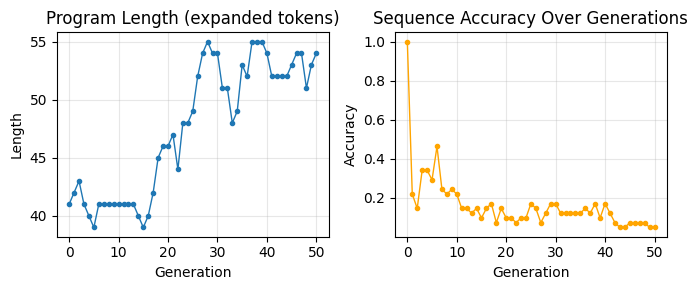

In [467]:
# %%

# Plot length and accuracy over generations
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

axes[0].plot(results_df["generation"], results_df["length_expanded"], marker=".", linewidth=1)
axes[0].set_xlabel("Generation")
axes[0].set_ylabel("Length")
axes[0].set_title("Program Length (expanded tokens)")
axes[0].grid(alpha=0.3)

axes[1].plot(results_df["generation"], results_df["accuracy"], marker=".", linewidth=1, color='orange')
axes[1].set_xlabel("Generation")
axes[1].set_ylabel( "Accuracy")
axes[1].set_title("Sequence Accuracy Over Generations")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

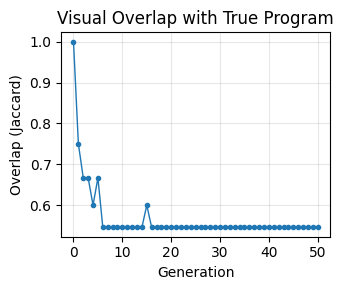

In [468]:
# %%

# Visual overlap over generations
plt.figure(figsize=(3.5,3))
plt.plot(results_df["generation"], results_df["visual_overlap"], marker=".", linewidth=1)
plt.xlabel("Generation")
plt.ylabel("Overlap (Jaccard)")
plt.title("Visual Overlap with True Program")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [469]:
# %%

selected_generations = [0, NUM_GENERATIONS // 5, NUM_GENERATIONS]
for g in selected_generations:
    prog_tokens = programs_over_time[g]
    expanded_tokens = expand_program(prog_tokens)
    prog_str_for_render = tokens_to_program(expanded_tokens)
    acc_g = float(results_df.loc[results_df["generation"] == g, "accuracy"].iloc[0])
    print(f"\nGeneration {g} (sequence accuracy = {acc_g:.3f}):")
    print(f"  {prog_str_for_render}")
    try:
        render_program(prog_str_for_render)
    except AssertionError:
        print("  [Rendering skipped: program moves blocks outside valid range]")
    except Exception as e:
        print(f"  [Rendering skipped due to error: {e}]")


Generation 0 (sequence accuracy = 1.000):
  h l_1 v v r_1 h r_6 h l_4 h l_1 v v r_6 h l_1 v v r_1 h r_6 h l_4 h l_1 v v r_6 h l_1 v v r_1 h r_6 h l_4 h l_1 v v
  [Rendering skipped: program moves blocks outside valid range]

Generation 10 (sequence accuracy = 0.220):
  r_1 l_1 v h l_4 r_1 h r_6 r_4 r_1 l_4 l_4 h v r_6 r_6 r_6 r_1 v r_1 r_6 h r_12 r_7 h r_12 r_4 r_6 l_5 l_1 r_9 l_4 h h r_12 r_12 r_12 r_7 l_1 v l_4
  [Rendering skipped: program moves blocks outside valid range]

Generation 50 (sequence accuracy = 0.049):
  r_6 h r_6 r_6 r_6 l_4 r_1 v v l_4 r_4 r_7 h h r_6 r_1 l_4 h r_4 v l_5 v r_4 l_1 r_4 r_6 v r_9 v h r_6 r_9 v r_9 r_4 l_5 r_6 h v r_7 h h r_1 v h r_4 r_12 l_5 r_12 l_1 l_1 h v l_4
  [Rendering skipped: program moves blocks outside valid range]


# %% [markdown]

  ## Multiple Chains: Complexity-Accuracy Trade-off

  Run many independent chains to explore the complexity-accuracy space.
  This shows the empirical efficiency frontier: the best accuracy achievable at each complexity level.

In [470]:
# %%

# Run many independent chains
all_rows = []
for chain_id in range(NUM_CHAINS):
    chain_model = TransmissionChain(dsl=DEFAULT_DSL, random_seed=SEED + chain_id)
    progs = chain_model.run_chain(true_tokens, num_generations=NUM_GENERATIONS)
    for gen_idx, prog_tokens in enumerate(progs):
        length_expanded = expanded_length(prog_tokens)
        acc = sequence_accuracy(true_tokens, prog_tokens)
        all_rows.append({
            "chain": chain_id,
            "generation": gen_idx,
            "length_expanded": length_expanded,
            "accuracy": acc,
        })

multi_df = pd.DataFrame(all_rows)
print(f"Collected {len(multi_df)} data points from {NUM_CHAINS} chains")
print("\nMulti-chain summary (first few rows):")
print(multi_df.head())

Collected 1275 data points from 25 chains

Multi-chain summary (first few rows):
   chain  generation  length_expanded  accuracy
0      0           0               41  1.000000
1      0           1               42  0.219512
2      0           2               43  0.146341
3      0           3               41  0.341463
4      0           4               40  0.341463


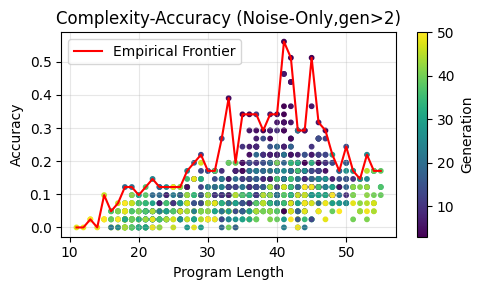

In [471]:
# %%

# Complexity-accuracy scatter plot (noise-only)
multi_df = multi_df[multi_df["generation"] > 2]

plt.figure(figsize=(5, 3))
sc = plt.scatter(
    multi_df["length_expanded"],
    multi_df["accuracy"],
    c=multi_df["generation"],
    s=10,
)
plt.colorbar(sc, label="Generation")
plt.xlabel("Program Length")
plt.ylabel("Accuracy")
plt.title("Complexity-Accuracy (Noise-Only,gen>2)")
plt.grid(alpha=0.3)

# Empirical efficiency frontier
frontier = (
    multi_df.groupby("length_expanded")["accuracy"]
    .max()
    .reset_index()
    .sort_values("length_expanded")
)
plt.plot(
    frontier["length_expanded"],
    frontier["accuracy"],
    color="red",
    label="Empirical Frontier"
)
plt.legend()
plt.tight_layout()
plt.show()

# %% [markdown]

  # 2 Selection-Based Transmission

  Add selection pressure: at each generation, choose the candidate that best balances compression and accuracy.
  This implements a soft Information Bottleneck objective at the token level.

In [472]:
# %%

# Run many chains with selection
all_rows_sel = []
for chain_id in range(NUM_CHAINS):
    chain_model = TransmissionChain(dsl=DEFAULT_DSL, random_seed=SEED + 100 + chain_id)
    progs = run_chain_with_selection(
        model=chain_model,
        true_program=true_tokens,
        num_generations=NUM_GENERATIONS,
        lambda_compression=LAMBDA_COMPRESSION,
        num_candidates=NUM_CANDIDATES_TOKEN,
        temperature=SELECTION_TEMPERATURE,
    )
    for gen_idx, prog_tokens in enumerate(progs):
        length_expanded = expanded_length(prog_tokens)
        acc = sequence_accuracy(true_tokens, prog_tokens)
        all_rows_sel.append({
            "chain": chain_id,
            "generation": gen_idx,
            "length_expanded": length_expanded,
            "accuracy": acc,
        })

multi_sel_df = pd.DataFrame(all_rows_sel)
print(f"Collected {len(multi_sel_df)} data points from {NUM_CHAINS} chains (with selection)")
print("\nMulti-chain (selection) summary (first few rows):")
print(multi_sel_df.head())

Collected 1275 data points from 25 chains (with selection)

Multi-chain (selection) summary (first few rows):
   chain  generation  length_expanded  accuracy
0      0           0               41  1.000000
1      0           1               43  0.609756
2      0           2               40  0.170732
3      0           3               41  0.268293
4      0           4               39  0.073171


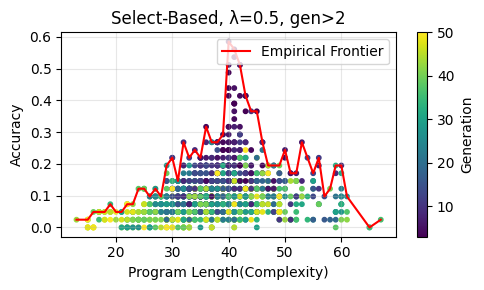

In [473]:
# %%

# Complexity-accuracy scatter plot (with selection)
multi_sel_df = multi_sel_df[multi_sel_df["generation"] > 2]

plt.figure(figsize=(5, 3))
sc2 = plt.scatter(
    multi_sel_df["length_expanded"],
    multi_sel_df["accuracy"],
    c=multi_sel_df["generation"],
    s=10,
)
plt.colorbar(sc2, label="Generation")
plt.xlabel("Program Length(Complexity)")
plt.ylabel("Accuracy")
plt.title(f"Select-Based, λ={LAMBDA_COMPRESSION}, gen>2")
plt.grid(alpha=0.3)

# Empirical frontier
frontier_sel = (
    multi_sel_df.groupby("length_expanded")["accuracy"]
    .max()
    .reset_index()
    .sort_values("length_expanded")
)
plt.plot(
    frontier_sel["length_expanded"],
    frontier_sel["accuracy"],
    color="red",
    label="Empirical Frontier"
)
plt.legend()
plt.tight_layout()
plt.show()

# %% [markdown]

  # 3 AST-Based IB with Fragment Learning

  The most sophisticated model:
  - **AST structure**: Programs represented as trees, enabling compositionality
  - **Fragment discovery**: Automatically learn reusable patterns from program history
  - **Explicit IB objective**: Minimize L = C - $\beta$·A where C = complexity, A = accuracy
  - **Structure-preserving reconstruction**: Agents reconstruct programs using learned fragments

# %% [markdown]

  ## Single AST-Based IB Chain

In [474]:
# %%

# Run AST-based IB chain
ib_chain, ib_library = run_chain_ib(
    initial_program=true_tokens,
    true_program=true_tokens,
    num_generations=NUM_GENERATIONS_AST,
    beta=BETA_IB,
    num_candidates=NUM_CANDIDATES_AST,
    fragment_discovery_freq=FRAGMENT_DISCOVERY_FREQ,
    temperature=IB_TEMPERATURE,
    noise_params=IB_NOISE_PARAMS,
    random_seed=SEED,
)

# Set the library for correct fragment expansion when computing metrics
set_library(ib_library)

# Collect AST-based metrics
ast_rows = []
for gen_idx, prog_tokens in enumerate(ib_chain):
    ast = tokens_to_ast(prog_tokens)
    true_ast = tokens_to_ast(true_tokens)
    
    length = expanded_length(prog_tokens)
    acc_seq = sequence_accuracy(true_tokens, prog_tokens)
    frag_use = fragment_usage(ast)
    ib_c = ib_complexity(ast)
    ib_a = ib_accuracy(ast, true_ast)
    ib_l = ib_loss(ast, true_ast, beta=BETA_IB)
    
    ast_rows.append({
        "generation": gen_idx,
        "length_expanded": length,
        "accuracy_seq": acc_seq,
        "fragment_usage": frag_use,
        "ib_complexity": ib_c,
        "ib_accuracy": ib_a,
        "ib_loss": ib_l,
    })

ast_df = pd.DataFrame(ast_rows)
print("AST-based IB chain summary (first few rows):")
print(ast_df.head())
print("\nAST-based IB chain final generations:")
print(ast_df.tail())

AST-based IB chain summary (first few rows):
   generation  length_expanded  accuracy_seq  fragment_usage  ib_complexity  \
0           0               41       1.00000        0.000000           42.0   
1           1               41       0.95122        0.000000           42.0   
2           2               13       0.00000        0.642857           14.0   
3           3               13       0.00000        0.642857           14.0   
4           4               13       0.00000        0.642857           14.0   

   ib_accuracy   ib_loss  
0      1.00000 -1.833333  
1      0.97619 -1.773810  
2      0.77381 -1.712302  
3      0.77381 -1.712302  
4      0.77381 -1.712302  

AST-based IB chain final generations:
    generation  length_expanded  accuracy_seq  fragment_usage  ib_complexity  \
46          46                4           0.0            0.60            5.0   
47          47                4           0.0            0.60            5.0   
48          48                4        

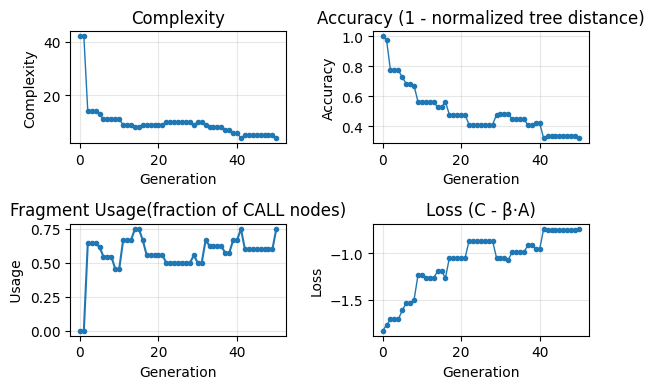

In [475]:
# %%

# Plot AST-based chain metrics
fig, axes = plt.subplots(2, 2, figsize=(6, 4))

axes[0, 0].plot(ast_df["generation"], ast_df["ib_complexity"], marker=".", linewidth=1)
axes[0, 0].set_xlabel("Generation")
axes[0, 0].set_ylabel("Complexity")
axes[0, 0].set_title("Complexity")
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(ast_df["generation"], ast_df["ib_accuracy"], marker=".", linewidth=1)
axes[0, 1].set_xlabel("Generation")
axes[0, 1].set_ylabel("Accuracy")
axes[0, 1].set_title("Accuracy (1 - normalized tree distance)")
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(ast_df["generation"], ast_df["fragment_usage"], marker=".")
axes[1, 0].set_xlabel("Generation")
axes[1, 0].set_ylabel(" Usage ")
axes[1, 0].set_title("Fragment Usage(fraction of CALL nodes)")
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(ast_df["generation"], ast_df["ib_loss"], marker=".", linewidth=1)
axes[1, 1].set_xlabel("Generation")
axes[1, 1].set_ylabel("Loss")
axes[1, 1].set_title("Loss (C - β·A)")
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

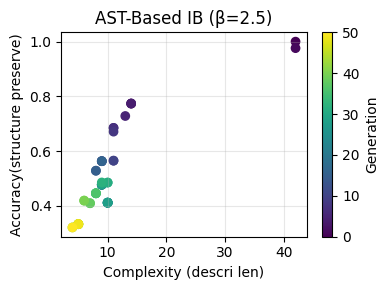

In [476]:
# %%

# Complexity-accuracy trajectory for single AST-based IB chain
plt.figure(figsize=(4,3))
sc_ast = plt.scatter(
    ast_df["ib_complexity"],
    ast_df["ib_accuracy"],
    c=ast_df["generation"]
)
plt.colorbar(sc_ast, label="Generation")
plt.xlabel("Complexity (descri len)")
plt.ylabel("Accuracy(structure preserve)")
plt.title(f"AST-Based IB (β={BETA_IB})")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# %% [markdown]

  ## Multiple AST-Based IB Chains: Fragment Emergence

  Run multiple chains to observe how fragments emerge and are used across different transmission histories.

In [477]:
# %%

# Run multiple AST-based IB chains

all_ast_rows = []

for chain_id in range(NUM_AST_CHAINS):
    chain, chain_library = run_chain_ib(
        initial_program=true_tokens,
        true_program=true_tokens,
        num_generations=NUM_GENERATIONS_AST,
        beta=BETA_IB,
        num_candidates=NUM_CANDIDATES_AST,
        fragment_discovery_freq=FRAGMENT_DISCOVERY_FREQ,
        temperature=IB_TEMPERATURE,
        noise_params=IB_NOISE_PARAMS,
        random_seed=SEED + 200 + chain_id,
    )
    
    # Set this chain's library for correct fragment expansion
    set_library(chain_library)
    
    for gen_idx, prog_tokens in enumerate(chain):
        ast = tokens_to_ast(prog_tokens)
        true_ast = tokens_to_ast(true_tokens)
        
        all_ast_rows.append({
            "chain": chain_id,
            "generation": gen_idx,
            "ib_complexity": ib_complexity(ast),
            "ib_accuracy": ib_accuracy(ast, true_ast),
            "fragment_usage": fragment_usage(ast),
        })

multi_ast_df = pd.DataFrame(all_ast_rows)
print(f"Collected {len(multi_ast_df)} data points from {NUM_AST_CHAINS} AST-based chains")
print(f"Fragment usage range: [{multi_ast_df['fragment_usage'].min():.3f}, {multi_ast_df['fragment_usage'].max():.3f}]")

Collected 1275 data points from 25 AST-based chains
Fragment usage range: [0.000, 0.909]


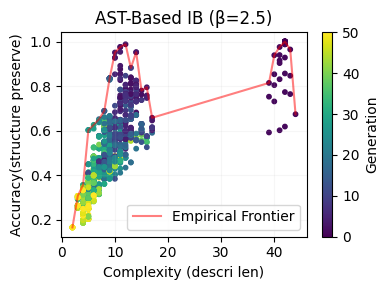

In [478]:
# %%

# IB frontier for AST-based chains
# multi_ast_df = multi_ast_df[multi_ast_df["generation"] > 2]

from turtle import width


plt.figure(figsize=(4, 3))
sc_multi = plt.scatter(
    multi_ast_df["ib_complexity"],
    multi_ast_df["ib_accuracy"],
    c=multi_ast_df["generation"],
    s=10,
)
plt.colorbar(sc_multi, label="Generation")
plt.xlabel("Complexity (descri len)")
plt.ylabel("Accuracy(structure preserve)")
plt.title(f"AST-Based IB (β={BETA_IB})")
plt.grid(alpha=0.1)

# Empirical IB frontier
frontier_ast = (
    multi_ast_df.groupby("ib_complexity")["ib_accuracy"]
    .max()
    .reset_index()
    .sort_values("ib_complexity")
)

plt.plot(
    frontier_ast["ib_complexity"],
    frontier_ast["ib_accuracy"],
    color="red",
    label="Empirical Frontier",
    alpha=0.5
)
plt.legend()
plt.tight_layout()
plt.show()

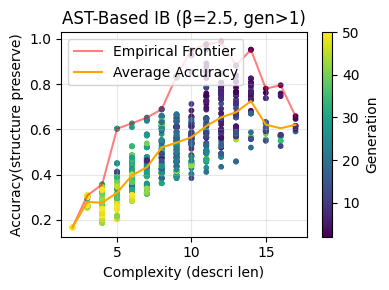

In [479]:
# %%

# IB frontier for AST-based chains
multi_ast_df = multi_ast_df[multi_ast_df["generation"] > 1]

plt.figure(figsize=(4, 3))
sc_multi = plt.scatter(
    multi_ast_df["ib_complexity"],
    multi_ast_df["ib_accuracy"],
    c=multi_ast_df["generation"],
    s=10,
)
plt.colorbar(sc_multi, label="Generation")
plt.xlabel("Complexity (descri len)")
plt.ylabel("Accuracy(structure preserve)")
plt.title(f"AST-Based IB (β={BETA_IB}, gen>1)")
plt.grid(alpha=0.3)

# Empirical IB frontier
frontier_ast = (
    multi_ast_df.groupby("ib_complexity")["ib_accuracy"]
    .max()
    .reset_index()
    .sort_values("ib_complexity")
)
plt.plot(
    frontier_ast["ib_complexity"],
    frontier_ast["ib_accuracy"],
    color="red",
    label="Empirical Frontier",
    alpha=0.5
)
# fit a line of average accuracy vs complexity to plot
avg_accuracy = multi_ast_df.groupby("ib_complexity")["ib_accuracy"].mean()
plt.plot(avg_accuracy.index, avg_accuracy.values, color="orange", label="Average Accuracy")

plt.legend()
plt.tight_layout()
plt.show()

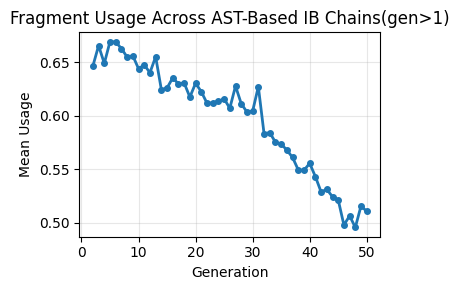

In [480]:
# %%

# Fragment usage over generations (averaged across chains)
frag_by_gen = multi_ast_df.groupby("generation")["fragment_usage"].mean().reset_index()

plt.figure(figsize=(4, 3))
plt.plot(frag_by_gen["generation"], frag_by_gen["fragment_usage"], marker=".", linewidth=2, markersize=8)
plt.xlabel("Generation")
plt.ylabel("Mean Usage")
plt.title("Fragment Usage Across AST-Based IB Chains(gen>1)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()